Kaggle dataset of 5,863 pediatric chest x-rays with lables of Normal and Pneumonia

https://www.kaggle.com/paultimothymooney/undefined


In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import os, os.path
from skimage import io
import copy

import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchsummary import summary

%matplotlib inline


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Working on device=cuda


The images were uploaded to Google Drive.  So we need to mount a drive to this location to allow this notebook access to the images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_path = "drive/My Drive/data/chest_xray/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Directory Structure
We are given 3 folders, "train", "val" and "test".  
Each of these folders contains subfolders with "Normal" and "Pneumonia"

The validation folder will not be used since it only contains 16 minages.

So we will randomly split the training folder into train and validate.

In [0]:
train_data_path = root_path + "train/"
val_data_path = root_path + "val/"
test_data_path = root_path + "test/"

train_normal_path = train_data_path + "NORMAL/"
train_pneumonia_path = train_data_path + "PNEUMONIA/"

val_normal_path = val_data_path + "NORMAL/"
val_pneumonia_path = val_data_path + "PNEUMONIA/"

test_normal_path = test_data_path + "NORMAL/"
test_pneumonia_path = test_data_path + "PNEUMONIA/"

In [4]:
train_normal_dir = os.listdir(train_normal_path)
train_pneumonia_dir = os.listdir(train_pneumonia_path)

val_normal_dir = os.listdir(val_normal_path)
val_pneumonia_dir = os.listdir(val_pneumonia_path)

test_normal_dir = os.listdir(test_normal_path)
test_pneumonia_dir = os.listdir(test_pneumonia_path)

print("Number of normal x-rays (train): ", len(train_normal_dir))
print("Number of pneumonia x-rays (train): ", len(train_pneumonia_dir))

print("Number of normal x-rays (val): ", len(val_normal_dir))
print("Number of pneumonia x-rays (val): ", len(val_pneumonia_dir))

print("Number of normal x-rays (test): ", len(test_normal_dir))
print("Number of pneumonia x-rays (test): ", len(test_pneumonia_dir))

Number of normal x-rays (train):  1360
Number of pneumonia x-rays (train):  3886
Number of normal x-rays (val):  8
Number of pneumonia x-rays (val):  8
Number of normal x-rays (test):  235
Number of pneumonia x-rays (test):  391


# Let's take a quick look at the images

These are randomly picked from the training images for each label

In [0]:
def plot_images(item_dir, top=10):
  dir = os.listdir(item_dir)
  all_files = [os.path.join(item_dir, file) for file in dir]
  top_files = np.random.choice(all_files, top)

  plt.figure(figsize = (15,15))
  for idx, img_path in enumerate(top_files):
    plt.subplot(5,5, idx+1)
    img = io.imread(img_path, as_gray=False)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.tight_layout()

## Normal

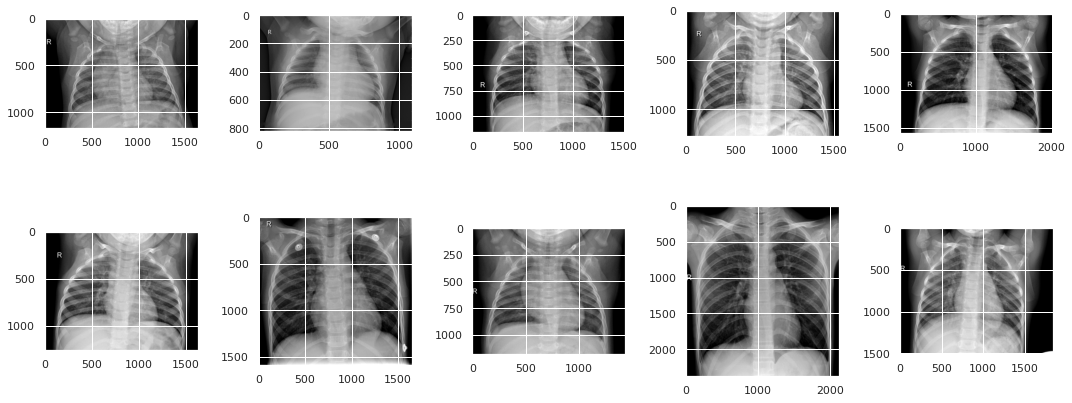

In [6]:
plot_images(train_normal_path)

## Pneumonia

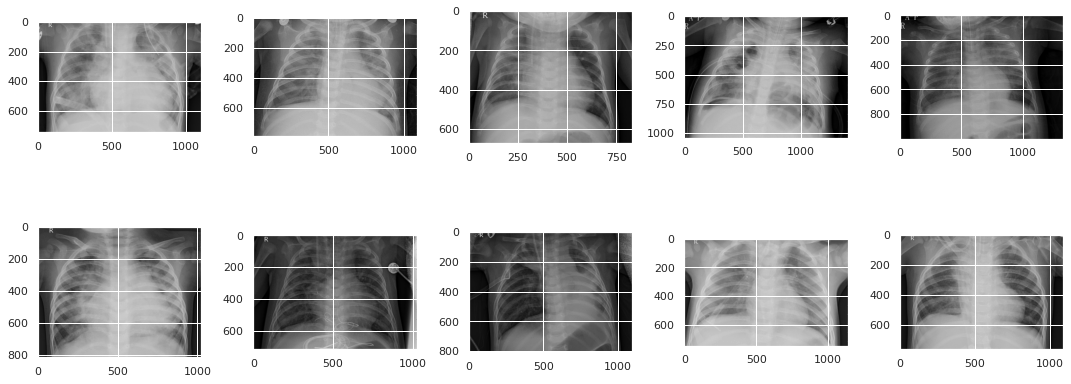

In [7]:
plot_images(train_pneumonia_path)

# Image Prep

We will need to prep the following transformations:
- Resize the images to a standard square shape
- Make sure the images are in gray scale
- Convert to pixels to PyTorch tensors

Since x-ray have strict procedural standards, we will not get images that are taken from different angles or way off center.  But there will be some variations.  If this child is in bed, has spinal diformaties or is not complient to holding a position, we will see some variation.  So, adding some small affine translations and rotations should help with generalizing the predictive value.

With this type of medical image, there could be leaks within the images.   Higher acuity patients may have their x-rays taken in bed, have EKG pads visible in the image or have other indicating factors.  These image features have a greater chance of being associated with pneumonia and bias the prediction.  But there is nothing to be done about this, but validation is key here to make sure these leaks don’t get out of hand.

We need to build 3 PyTorch objects:
-	Transform
-	Dataset
-	DataLoader

This needs to be done train, val and test.  

Since we were only given 16 images for validation, we will want to split the training images into 2 datasets.  80% towards train and 20% towards validation.  Ideally, we would want to use cross validation folds for this, but for now, we will just do a single split.




### Parameters needed for Transformation and Loader

In [0]:
hight = 224
width = 224
channels = 1
batch_size = 16
num_classes = 2

### Pixel Mean and SD for Image Normalization
Before we build or torchvision objects, we need to do a random sample of our training images to get the mean and standard deviation of the pixel distribution.

We need to use some the same preprocessing PyTorch will do such for the resize and gray scaling so are statistics are accurate.

So, we create throwaway transform, dataset, and loader object just for this calculation.  We will have to create new object for the real training data.



In [9]:
def get_image_statistics(dir, sample_size = 500):
  transform = transforms.Compose(
                                  [transforms.Resize(size=(hight,width), interpolation=2),
                                  transforms.Grayscale(1),
                                  transforms.ToTensor()])
  ds = torchvision.datasets.ImageFolder(root=dir, transform=transform)
  dss = torch.utils.data.Subset(ds, np.random.choice(len(ds), sample_size, replace=False))
  loader = torch.utils.data.DataLoader(dss, batch_size=sample_size)
  image_count = 0
  fst_moment = torch.empty(1)
  snd_moment = torch.empty(1)

  for images, _ in loader:

      b, c, h, w = images.shape
      nb_pixels = b * h * w
      sum_ = torch.sum(images, dim=[0, 2, 3])
      sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
      fst_moment = (image_count * fst_moment + sum_) / (image_count + nb_pixels)
      snd_moment = (image_count * snd_moment + sum_of_square) / (image_count + nb_pixels)

      image_count += nb_pixels

  return fst_moment, torch.sqrt((snd_moment - fst_moment) ** 2)
train_img_mean, train_img_std = get_image_statistics(train_data_path)
train_img_mean, train_img_std 

(tensor([0.4833]), tensor([0.1941]))

In [10]:
train_img_mean, train_img_std = get_image_statistics(train_data_path)
train_img_mean, train_img_std 

(tensor([0.4832]), tensor([0.1933]))

In [11]:
test_img_mean, test_img_std = get_image_statistics(test_data_path)
test_img_mean, test_img_std 

(tensor([0.4728]), tensor([0.1935]))

### Build the Actual Transformation Object

We could not do this before since we needed the mean and SD first

In [0]:
train_transform = transforms.Compose(
    [transforms.Resize(size=(hight,width), interpolation=2),
     transforms.Grayscale(1),
     transforms.ToTensor(),
    #  transforms.RandomAffine(degrees=5, translate=(.1,.1), shear=5),
     transforms.Normalize((train_img_mean,), (train_img_std,))])

val_transform = transforms.Compose(
    [transforms.Resize(size=(hight,width), interpolation=2),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize((train_img_mean,), (train_img_std,))])

test_transform = transforms.Compose(
    [transforms.Resize(size=(hight,width), interpolation=2),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize((test_img_mean,), (test_img_std,))])

classes = ('NORMAL', 'PNEUMONIA')

In [16]:
train_dataset = torchvision.datasets.ImageFolder(
        root=train_data_path,
        transform=train_transform
    )
print("train labels", train_dataset.classes)
'''
The Kaggle validation folder only has 16 images.  
Lets do an 80/20 split of the training dataset instead.
'''
train_length = int(len(train_dataset)*.8)
val_length = int(len(train_dataset) - train_length)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_length, val_length])

#make sure validation DS uses the test transformation
val_dataset = copy.deepcopy(val_dataset)
val_dataset.dataset.transform = val_transform

train_subset_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

val_subset_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

test_dataset = torchvision.datasets.ImageFolder(
        root=test_data_path,
        transform=test_transform,
    )
print("test labels: ", test_dataset.classes)
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )


train labels ['NORMAL', 'PNEUMONIA']
test labels:  ['NORMAL', 'PNEUMONIA']


# Build CNN

In [0]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [20]:
NUM_CLASSES = 2
net = resnet18(NUM_CLASSES)
net = nn.DataParallel(net)
net.to(device)


learning_rate = 1e-4
num_epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=learning_rate)#, weight_decay=0.9)

summary(net, (channels, hight, width))

NameError: ignored

In [0]:
train_accuracy_index = []
train_acc, train_total, train_correct = 0, 0, 0
val_accuracy_index = []
val_acc, val_total, val_correct = 0, 0, 0
test_accuracy_index = []
test_acc, test_total, test_correct = 0, 0, 0
losses_index = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = datetime.now()
    net.train()
    running_loss = 0.0
    epoch_loss = 0
    for i, data in enumerate(train_subset_loader, 0):
        # get the inputs
        inputs, labels = data
        # move data to device GPU OR CPU
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        
        #Get Training Accuracty
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_acc = train_correct/train_total
        train_accuracy_index.append(train_acc)

        #loss, back prop and update params
        loss = criterion(outputs, labels)#.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(train_subset_loader)
    time_elapsed = datetime.now() - start_time
    losses_index.append(epoch_loss)
    
    # Validation set
    net.eval()
    with torch.no_grad():
      for data in val_subset_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()
          val_acc = val_correct/val_total
      val_accuracy_index.append(val_acc)

      for data in test_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          test_total += labels.size(0)
          test_correct += (predicted == labels).sum().item()
          test_acc = test_correct/test_total
      test_accuracy_index.append(test_acc)
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Ephch Loss: {epoch_loss:.4f} Training Accuracy: {train_acc:.4f}  Validation Accuracy: {val_acc:.4f} Test Accuracy: {test_acc:.4f} - (time={time_elapsed})')